In [1]:
import sys,os
sys.path.append("../")

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import HTML
from sklearn.metrics import pairwise_distances  


%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy import stats
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import entropy
import itertools

from sklearn.metrics import completeness_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import v_measure_score

import seaborn as sns


from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import pairwise_distances  
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score

sns.set()
sns.set_style("darkgrid")

### Function to take weighted entropy

In [2]:
def weighted_entropy(dataframe, entropy_column, group_columns="cluster", ):
    group_size = dataframe.groupby(group_columns).size()
    group_entropy = dataframe.groupby(group_columns)[entropy_column].apply(lambda x: entropy(x.value_counts().values))
    weighted_entropy = (group_size * group_entropy).mean()
    return weighted_entropy

## reading the change object.

In [3]:
article_name = "John_Logie_Baird"
change_object_dir =  "../data/change objects/"
content_dir = "../data/content/"
filename =  f"{article_name}_change.h5"
change_object_file = os.path.join(change_object_dir, filename)
filename = article_name + ".h5"
filepath = os.path.join(content_dir, filename)
with pd.HDFStore(filepath, 'r') as store:
    token_string_df = store.get("all_tokens")

token_string_df = token_string_df.set_index("token_id")["str"]
token_string_df[-1] = "St@rt"
token_string_df[-2] = "$nd"


if os.path.exists(change_object_file):
    with pd.HDFStore(change_object_file, 'r') as store:
        change_object_dataframe = store.get("data")
else:
    print("file do not exist")
change_object_dataframe.shape


change_object_dataframe["ins_length"] = change_object_dataframe["ins_tokens"].str.len()
change_object_dataframe["del_length"] = change_object_dataframe["del_tokens"].str.len()

change_object_dataframe["del_string_tokens"] = change_object_dataframe["del_tokens"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist()))

change_object_dataframe["ins_string_tokens"] = change_object_dataframe["ins_tokens"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist()))
change_object_dataframe["edit_string_tokens"] = change_object_dataframe["ins_string_tokens"] + change_object_dataframe["del_string_tokens"]



change_object_dataframe["left_context"] = change_object_dataframe["left_token"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist())).str.join(" ")


change_object_dataframe["right_context"] = change_object_dataframe["right_token"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist())).str.join(" ")

change_object_dataframe["bykau_cluster"] = pd.Series(-99,index=change_object_dataframe.index)

# change_object_dataframe = change_object_dataframe[["left_context","del_string_tokens","ins_string_tokens", "right_context", 
#                                                    "ins_length", "del_length", "bykau_cluster" ]]
change_object_dataframe.head()

ins_start_pos  \
from revision id to revision id timestamp           timegap           editor                    
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0           10.0   
                                                                             1           32.0   
                                                                             2           34.0   
                                                                             3           50.0   
                                                                             4           57.0   

                                                                                ins_end_pos  \
from revision id to revision id timestamp           timegap           editor                  
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0         30.0   
                                                                             1         32.0   
                                                                             2         34.0   
                                                                             3         55.0   
                                                                             4         73.0   

                                                                                left_neigh  \
from revision id to revision id timestamp           timegap           editor                 
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0           9   
                                                                             1          10   
                                                                             2          11   
                                                                             3          26   
                                                                             4          32   

                                                                                right_neigh  \
from revision id to revision id timestamp           timegap           editor                  
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0           10   
                                                                             1           11   
                                                                             2           12   
                                                                             3           32   
                                                                             4           36   

                                                                                del_start_pos  \
from revision id to revision id timestamp           timegap           editor                    
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0           -1.0   
                                                                             1           -1.0   
                                                                             2           -1.0   
                                                                             3           27.0   
                                                                             4           33.0   

                                                                                del_end_pos  \
from revision id to revision id timestamp           timegap           editor                  
203693           203699         2002-09-08 14:05:32 194 days 22:14:17 3646   0         -1.0   
                                                                             1         -1.0   
                                                                             2         -1.0   
                                                                             3         31.0   
                                                                             4         35.0   

                                                               

In [4]:
change_object_dataframe.shape

(4900, 20)

## Reduce the change object.

In [8]:
ins_and_del = change_object_dataframe[(change_object_dataframe["ins_string_tokens"]!=()) & (change_object_dataframe["del_string_tokens"]!=())]
display(ins_and_del.shape)

(2018, 20)

### Removing change object with insert or delete token size more than five.

In [9]:
reduced_ins_and_del = ins_and_del[~((ins_and_del["ins_length"] >5 ) | (ins_and_del["del_length"] >5) )]
reduced_ins_and_del.shape

(1542, 20)

In [10]:
reduced_ins_and_del.reset_index(drop=True)[["ins_string_tokens", "del_string_tokens"]].sample(3)

,ins_string_tokens,del_string_tokens
195,"(:,)","(., later)"
342,"(inventions,)","(indevtions,)"
289,"(chuck,)","(chuk,)"


### Removing low user support tokens

In [11]:
bykau_change_object = reduced_ins_and_del.groupby("ins_string_tokens").filter(lambda x : x.index.get_level_values("editor").nunique()>=2)
bykau_change_object = bykau_change_object.groupby("del_string_tokens").filter(lambda x : x.index.get_level_values("editor").nunique()>=2)
bykau_change_object.shape

(493, 20)

#### read annotations

In [12]:
file_name = article_name + "_FULL.csv"
annotation_dir = "../data/annotation/"
full_file_path = os.path.join(annotation_dir, file_name)
annotation_df = pd.read_csv(full_file_path)
annotation_df = annotation_df[["revid_ctxt", "token_id",
                               "rev_id", "nationality", "birth_place","Bulk" ]]
true_labels = np.zeros((annotation_df.shape[0]))
true_labels[(annotation_df["nationality"].str.strip() == "Y").values] = 1
annotation_df["nationality"] = true_labels

## Function for weighted entropy

In [13]:
def weighted_token_entropy(dataframe, group_by):
    cluster_sizes = dataframe.groupby(group_by).size()
    token_entropy_clusters = dataframe.groupby(group_by)["edit_string_tokens"].apply(
                    lambda token_tuples: entropy(pd.Series(
                    [token for token_tuple in token_tuples.tolist() for token in token_tuple]
                    ).value_counts().values))
    cluster_entropy = (cluster_sizes * token_entropy_clusters).sum()
    return cluster_entropy

### Clustering using jaccard

##### Defining jaccard similarity function.

In [14]:
def bykau_distances(dataframe, context = 8):
    left_neighbours = dataframe["left_context"].apply(lambda x: x.split(" ")[-context:])
    right_neighbours = dataframe["right_context"].apply(lambda x: x.split(" ")[:context])
    
    neighbour_tokens = left_neighbours + right_neighbours
    neighbour_tokens_set = neighbour_tokens.apply(lambda x: np.unique(x))
    
    neighbour_vec = MultiLabelBinarizer().fit_transform(neighbour_tokens_set)
    return pairwise_distances(neighbour_vec, metric="jaccard")
#     db = DBSCAN(eps=eps, min_samples=min_samples, metric='jaccard').fit(neighbour_vec)
#     return db.labels_ 

In [15]:
def bykau_cluster(distances, eps=0.75, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(distances)
    return db.labels_ 


In [16]:
def token_in_gap(ann, gap_df, gap_cluster_df):
    context_gap = gap_df.loc[ann[['revid_ctxt', 'rev_id']]]
    context_cluster = gap_cluster_df.loc[ann[['revid_ctxt', 'rev_id']]]
    clusters = context_cluster.loc[ context_gap["token_id"].apply(
            lambda x: ann["token_id"] in x),:].values
    if clusters.size >0:
            clusters = pd.Series(clusters[0],index=gap_cluster_df.columns)
    else:
        clusters = pd.Series(-10, index=gap_cluster_df.columns)
    return clusters

In [17]:
def evaluate_bykau(change_object_dataframe, annotation_df):
    ins_array = change_object_dataframe.reset_index().loc[
    change_object_dataframe["ins_start_pos"].values != -1, 
                  ["to revision id","ins_tokens", 'to revision id', "bykau_cluster"]].values

    # delete array is always done in from revision so taking it and leaving other change object where delete does not come.
    del_array = change_object_dataframe.reset_index().loc[
    change_object_dataframe["del_start_pos"].values != -1, 
                  ["from revision id","del_tokens", 'to revision id',"bykau_cluster"]].values

    gap_array = np.concatenate([ins_array,del_array], axis=0)
    gap_df = pd.DataFrame(gap_array,columns= ["revid_ctxt", "token_id", "rev_id","bykau_cluster"])
    gap_df = gap_df.set_index(['revid_ctxt', 'rev_id'])
    
    annotation_df["bykau_cluster"] = annotation_df.apply(token_in_gap, axis=1, args=(gap_df,))
    nationality_cluster = np.zeros((annotation_df.shape[0]))
    nationality_cluster[annotation_df["nationality"].str.strip() == "Y"] = 1
    annotation_df["nationality_cluster"] = nationality_cluster

    evaluation_score = pd.Series(index=["rand", "entropy",])
    evaluation_score["rand"] = adjusted_rand_score( annotation_df["bykau_cluster"], nationality_cluster)
    evaluation_score["entropy"] = weighted_entropy(annotation_df, group_columns="bykau_cluster", entropy_column="nationality_cluster")
    return evaluation_score   

In [18]:
context_array  = np.array([2, 4, 8, 15, 30])
eps_array =[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0,2.25, 2.5, 2.75, 3.0, 3.25,3.75,4.0]

min_samples_array = 2
all_combinations = list(itertools.product(context_array, eps_array))

idx = pd.MultiIndex.from_product([context_array, eps_array],
                                names=["context","eps"])




bykau_cluster_df =  pd.DataFrame(columns=idx, index= bykau_change_object.index) #pd.DataFrame(columns=idx)

bykau_evaluation_df = pd.DataFrame(index=idx)


In [19]:
for context in context_array:
    distances = bykau_distances(bykau_change_object, context = context)
    for eps in eps_array:
        clusters = bykau_cluster(distances, eps=eps)
        
        bykau_cluster_df.loc[bykau_change_object.index, (context, eps)] = pd.Series(clusters, index=bykau_change_object.index)

/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/envs/wrod2vec/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/ubuntu/anaconda3/envs/wrod2vec

In [20]:
# insert array is always done in to revision so taking it and leaving other change object where 
ins_array = bykau_change_object.reset_index().loc[
    bykau_change_object["ins_start_pos"].values != -1, 
                  ["to revision id","ins_tokens", 'to revision id']].values
ins_cluster = bykau_cluster_df.loc[
    bykau_change_object["ins_start_pos"].values != -1, :]

# delete array is always done in from revision so taking it and leaving other change object where delete does not come.
del_array = bykau_change_object.reset_index().loc[
    bykau_change_object["del_start_pos"].values != -1, 
                  ["from revision id","del_tokens", 'to revision id']].values
del_cluster = bykau_cluster_df.loc[
    bykau_change_object["del_start_pos"].values != -1, :]

gap_array = np.concatenate([ins_array,del_array], axis=0)
gap_df = pd.DataFrame(gap_array,columns=["revid_ctxt", "token_id",
                               "rev_id"])

gap_cluster= pd.concat([ins_cluster, del_cluster], axis=0)
gap_df = gap_df.set_index(['revid_ctxt', 'rev_id'])
gap_cluster_df = pd.concat([ins_cluster, del_cluster], axis=0)

gap_cluster_df.index=gap_df.index

In [21]:
# Finding the tokens who were in the gap.
al_combination_clusters_df = annotation_df.apply(token_in_gap, axis=1, args=(gap_df, gap_cluster_df))

annotation_clusters = pd.concat([annotation_df, al_combination_clusters_df], axis=1)

annotation_clusters.head()
# true_labels[true_lable_df["birth_place"].str.strip() == "Y"] = 2

,revid_ctxt,token_id,rev_id,nationality,birth_place,Bulk,"(2, 0.25)","(2, 0.5)","(2, 0.75)","(2, 1.0)",...,"(30, 1.5)","(30, 1.75)","(30, 2.0)","(30, 2.25)","(30, 2.5)","(30, 2.75)","(30, 3.0)","(30, 3.25)","(30, 3.75)","(30, 4.0)"
0,26479217,2127,26479217,0.0,Y,N,-10,-10,-10,-10,...,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10
1,26479217,2180,26479217,0.0,Y,N,-10,-10,-10,-10,...,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10
2,34662413,2507,34662413,0.0,Y,Y,-10,-10,-10,-10,...,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10
3,36934652,2127,38966139,0.0,Y,N,-10,-10,-10,-10,...,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10
4,39102207,2574,39102207,0.0,Y,N,-10,-10,-10,-10,...,-10,-10,-10,-10,-10,-10,-10,-10,-10,-10


# Calculating the entropy of the Annotated change objects

In [22]:
df2 = gap_df.copy()
df2=df2.reset_index()
df2['nationality'] = 0

aci = annotation_clusters.set_index(['revid_ctxt', 'rev_id']).sort_index()
aci = aci[aci['Bulk'] =='N']
aci_y=aci[aci['nationality'] == 1]
aci_n=aci[aci['nationality'] == 0]

counter = 0
def nat_val(row):
    global counter
    val = 0
    x=0
    y=0
    try:
        x = int(aci_y.loc[(row[0],row[1]), ['token_id']].isin(row[2]).sum())
        val = val + (1 if x > 0 else 0)
        
    except KeyError as e:
        pass
    try:
        y = int(aci_n.loc[(row[0],row[1]), ['token_id']].isin(row[2]).sum())
        val = val - (1 if y > 0 else 0)
        counter += y
    except KeyError as e:
        pass
#     if (1 if x > 0 else 0) + (1 if y > 0 else 0) > 1:
#         try:
#             if not (aci.loc[(row[0],row[1]),['Bulk']] == 'Y').all()[0]:
#                 print((aci.loc[(row[0],row[1]),['token_id','nationality','Bulk']])[aci.loc[(row[0],row[1]), 'token_id'].isin(row[2])])
#                 print(aci.loc[(row[0],row[1]), ['token_id']].isin(row[2]))
#         except:
#             import pdb; pdb.set_trace()
    return val 
    
df2['nationality'] = df2[['revid_ctxt', 'rev_id', 'token_id']].apply(nat_val, axis=1)
df3 = pd.concat([df2, gap_cluster_df.reset_index()], axis=1)
df3['nationality'].value_counts()

 0    674
 1    269
-1     43
Name: nationality, dtype: int64

In [29]:
entropies = []
print("Without bulks")
for context, eps in all_combinations:
#     print(str((context, eps)) + ": " + str(weighted_entropy(df3, entropy_column="nationality", group_columns=(context, eps))))
#     bykau_evaluation_df["entropy_change"].sort_values().iloc[0:20]
    bykau_evaluation_df.loc[(context, eps),"change_object_entropy"] = weighted_entropy(df3, 
                                                                            entropy_column="nationality", 
                                                                            group_columns=(context, eps))
        
    bykau_evaluation_df.loc[(context,eps),"change_object_completness"] = completeness_score(
        df3["nationality"], df3[(context, eps)])
    bykau_evaluation_df.loc[(context, eps),"change_object_homegenity"] = homogeneity_score(
        df3["nationality"], df3[(context, eps)])
    bykau_evaluation_df.loc[(context, eps),"change_object_vmeasure"] = v_measure_score(
        df3["nationality"], df3[(context, eps)])



Without bulks


# Calculating the entropy of the Annotated cases

In [30]:
# a = annotation_df.loc[al_combination_clusters_df.mean(axis=1) > -10]
# b = al_combination_clusters_df.loc[al_combination_clusters_df.mean(axis=1) > -10]

# annotation_clusters = pd.concat([a,b], axis=1)

In [31]:
# df4 = annotation_clusters[annotation_clusters['Bulk']=='N']
# for context,min_samples, eps in all_combinations:
#     bykau_evaluation_df.loc[(context,min_samples, eps),"row_based_entropy"] = weighted_entropy(df4, 
#                                                                                 entropy_column="nationality", 
#                                                                                 group_columns=(context,min_samples, eps))
# #     bykau_evaluation_df.loc[(context,min_samples, eps),"rand"] = adjusted_rand_score(df4[(context, min_samples,
# #                                                                                                       eps)], 
# #                                                                                  df4["nationality"])
            
#     bykau_evaluation_df.loc[(context,min_samples, eps),"row_based_completness"] = completeness_score(
#         df4["nationality"], df4[(context,min_samples, eps)])
#     bykau_evaluation_df.loc[(context,min_samples, eps),"row_based_homegenity"] = homogeneity_score(df4["nationality"], df4[(context,min_samples, eps)])
#     bykau_evaluation_df.loc[(context,min_samples, eps),"row_based_vmeasure"] = v_measure_score(df4["nationality"], df4[(context,min_samples, eps)])



    

# bykau_evaluation_df.head(10)
# #bykau_evaluation_df["entropy"].sort_values().iloc[0:20]

In [32]:
bykau_evaluation_df

gap_entropy  change_object_entropy  change_object_completness  \
context eps                                                                   
2       0.25  1351.511291              16.207738                   0.197539   
        0.50  1189.785146              15.043950                   0.221971   
        0.75  1624.232097              91.964015                   0.125452   
        1.00  1810.720414             740.519105                   1.000000   
        1.25  1810.720414             740.519105                   1.000000   
        1.50  1810.720414             740.519105                   1.000000   
        1.75  1810.720414             740.519105                   1.000000   
        2.00  1810.720414             740.519105                   1.000000   
        2.25  1810.720414             740.519105                   1.000000   
        2.50  1810.720414             740.519105                   1.000000   
        2.75  1810.720414             740.519105                   1.000000   
        3.00  1810.720414             740.519105                   1.000000   
        3.25  1810.720414             740.519105                   1.000000   
        3.75  1810.720414             740.519105                   1.000000   
        4.00  1810.720414             740.519105                   1.000000   
4       0.25  1432.433829              21.807398                   0.204804   
        0.50  1312.667069              21.302002                   0.207809   
        0.75  1678.836303             171.056646                   0.100965   
        1.00  1810.720414             740.519105                   1.000000   
        1.25  1810.720414             740.519105                   1.000000   
        1.50  1810.720414             740.519105                   1.000000   
        1.75  1810.720414             740.519105                   1.000000   
        2.00  1810.720414             740.519105                   1.000000   
        2.25  1810.720414             740.519105                   1.000000   
        2.50  1810.720414             740.519105                   1.000000   
        2.75  1810.720414             740.519105                   1.000000   
        3.00  1810.720414             740.519105                   1.000000   
        3.25  1810.720414             740.519105                   1.000000   
        3.75  1810.720414             740.519105                   1.000000   
        4.00  1810.720414             740.519105                   1.000000   
...                   ...                    ...                        ...   
15      0.25  1407.983410              19.426250                   0.198683   
        0.50  1361.086484              29.155810                   0.138703   
        0.75  1636.577780             115.250787                   0.077513   
        1.00  1810.720414             740.519105                   1.000000   
        1.25  1810.720414             740.519105                   1.000000   
        1.50  1810.720414             740.519105                   1.000000   
        1.75  1810.720414             740.519105                   1.000000   
        2.00  1810.720414             740.519105                   1.000000   
        2.25  1810.720414             740.519105                   1.000000   
        2.50  1810.720414             740.519105                   1.000000   
        2.75  1810.720414             740.519105                   1.000000   
        3.00  1810.720414             740.519105                   1.000000   
        3.25  1810.720414             740.519105                   1.000000   
        3.75  1810.720414             740.519105                   1.000000   
        4.00  1810.720414             740.519105                   1.000000   
30      0.25  1380.219728              21.634984                   0.156289   
        0.50  1343.767503              31.087479                   0.115025   
        0.75  1782.296476             363.710989                

### **@Aadil**, the rankindex here is wrong because all the nationality clusters hould be mark as one


In [33]:
def weighted_token_entropy(dataframe, group_by):
    cluster_sizes = dataframe.groupby(group_by).size()
    token_entropy_clusters = dataframe.groupby(group_by)["edit_string_tokens"].apply(
                    lambda token_tuples: entropy(pd.Series(
                    [token for token_tuple in token_tuples.tolist() for token in token_tuple]
                    ).value_counts().values))
    cluster_entropy = (cluster_sizes * token_entropy_clusters).sum()
    return cluster_entropy

In [41]:
#bykau_cluster_df.index = change_object_dataframe.index
bykau_cluster_df.index = bykau_change_object.index


bykau_optimised = pd.concat([bykau_change_object, bykau_cluster_df], axis=1)

In [42]:
entropy_series_with_optimization = pd.Series(index=all_combinations)

for context_eps_tuple in all_combinations:
    bykau_evaluation_df.loc[context_eps_tuple,
                                              "gap_entropy"] = weighted_token_entropy(bykau_optimised, 
                                                                                        context_eps_tuple)

In [43]:
bykau_evaluation_df[['change_object_completness', 'change_object_homegenity',
    "change_object_vmeasure", "gap_entropy",]].astype(np.float64).corr()

,change_object_completness,change_object_homegenity,change_object_vmeasure,gap_entropy
change_object_completness,1.000000,-0.798606,-0.857511,0.851718
change_object_homegenity,-0.798606,1.000000,0.988415,-0.984534
change_object_vmeasure,-0.857511,0.988415,1.000000,-0.976839
gap_entropy,0.851718,-0.984534,-0.976839,1.000000


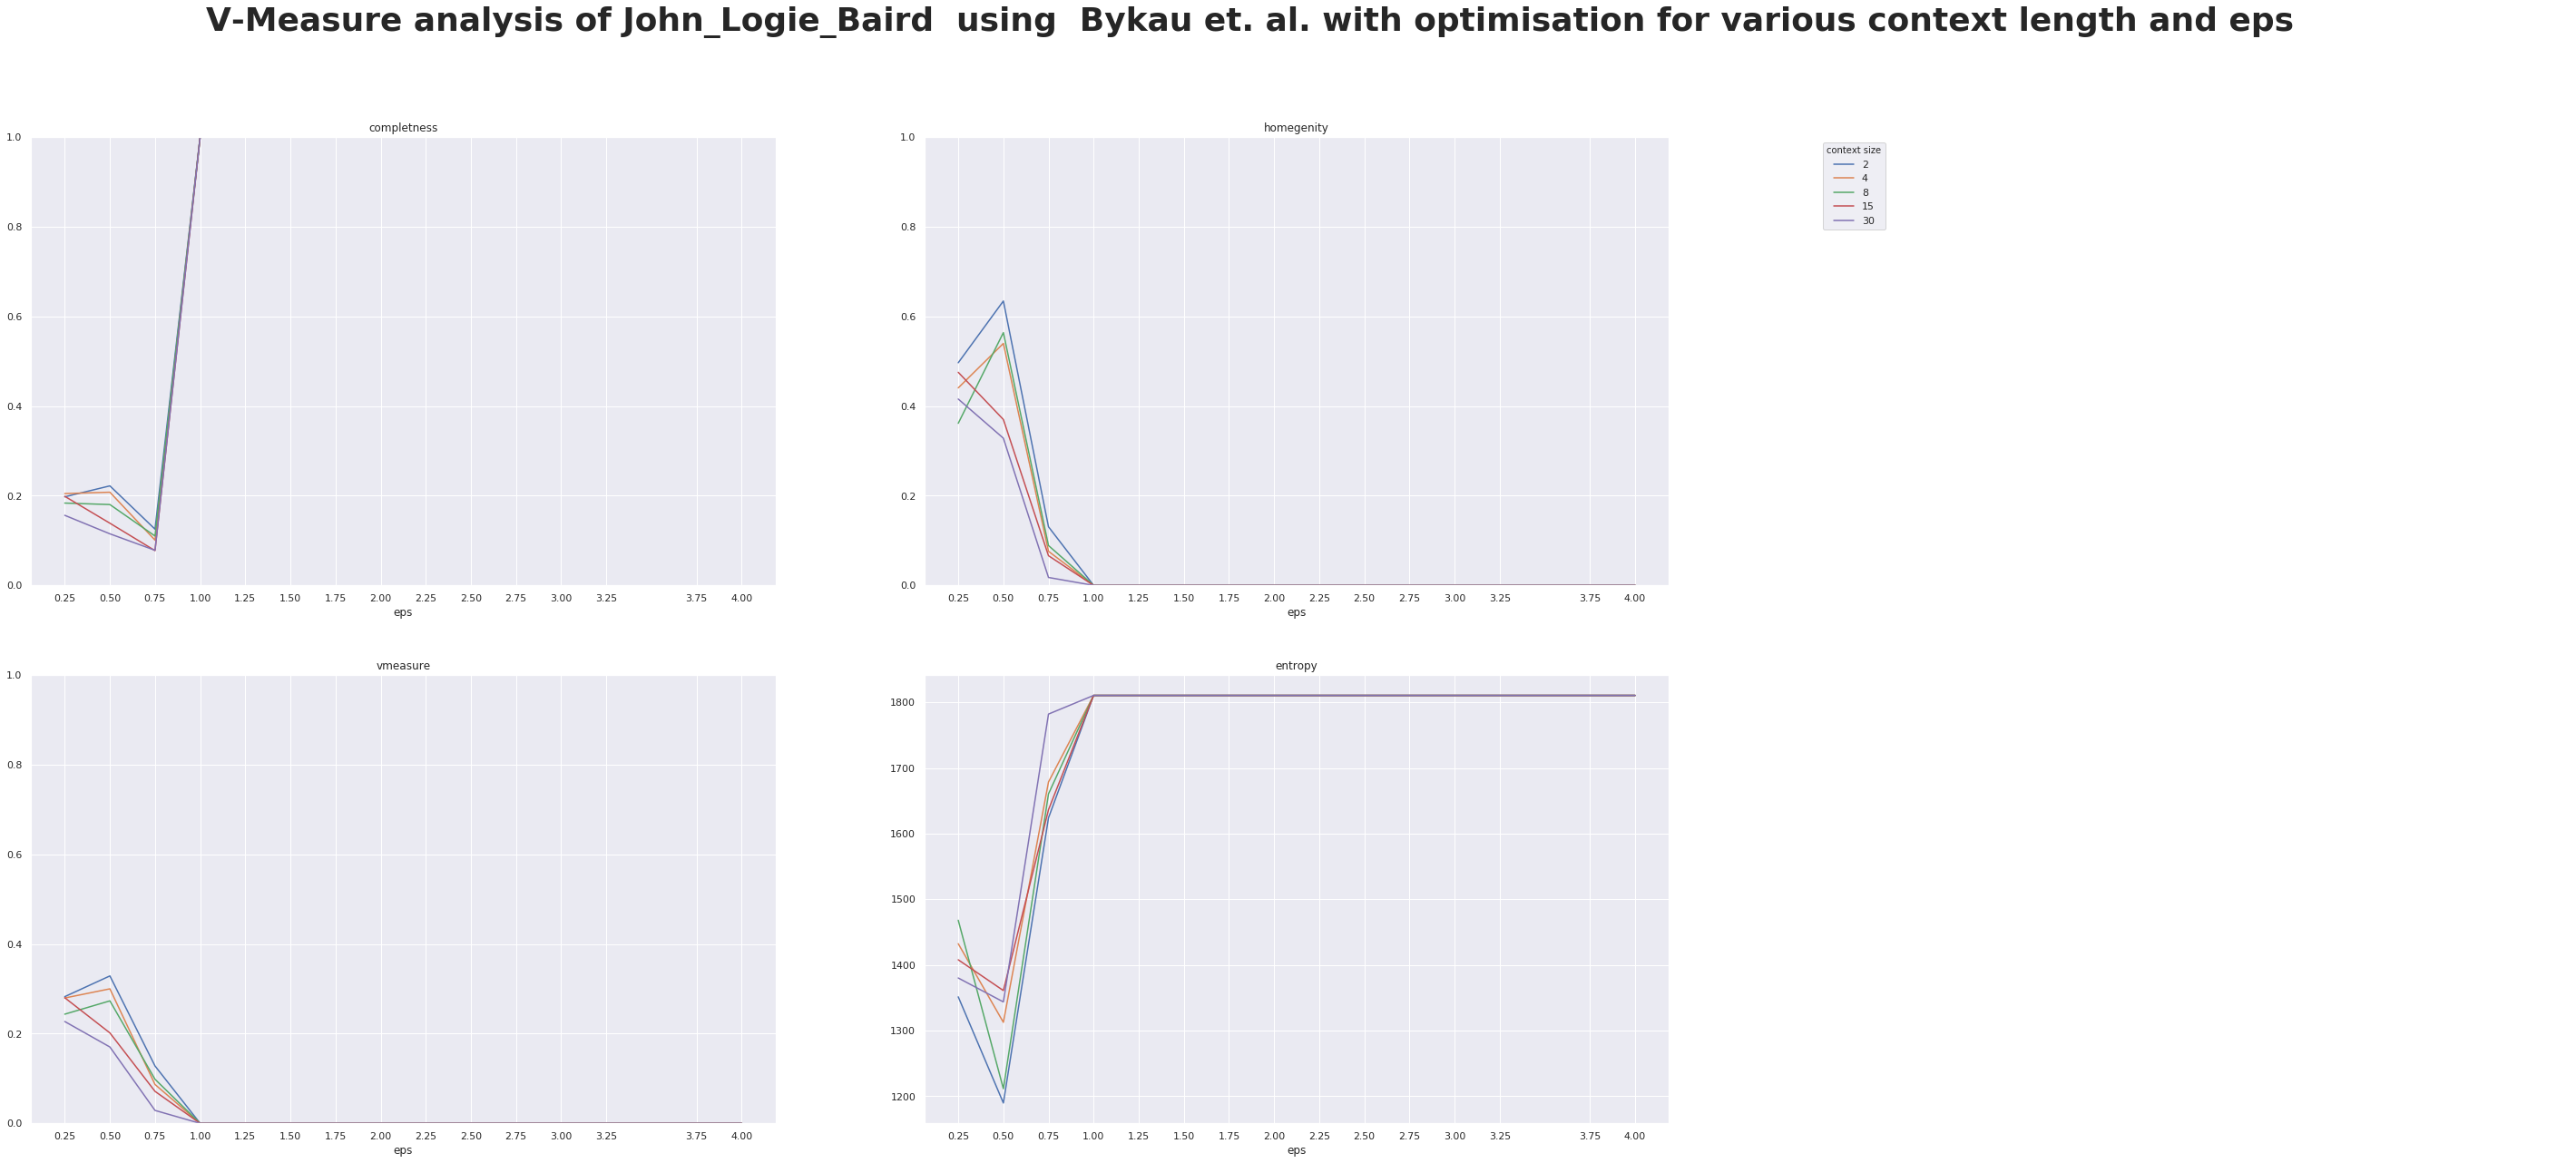

In [54]:
_df = bykau_evaluation_df.reset_index()

cols = [
    'change_object_completness', 'change_object_homegenity', "Legend",
    "change_object_vmeasure", "gap_entropy",
]


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(50,20))
fig.suptitle(f'V-Measure analysis of John_Logie_Baird  using  Bykau et. al. with optimisation for various context length and eps ',
             fontsize=36, fontweight="bold")
axes[0,0].set_ylim([0,1])
axes[0,1].set_ylim([0,1])
axes[1,0].set_ylim([0,1])



for i, column in enumerate(cols):
    if column =="Legend":
            
            handles, labels = _ax.get_legend_handles_labels()
            #fig.legend(handles, labels, loc='lower right')
            _ax = axes[int(i/3),i%3]
            _ax.legend(handles, labels, loc='upper left')
            _ax.axis('off')

    else:
#         _ax = axes[i]
        _ax = axes[int(i/3),i%3]


#         _ax.xaxis.label.set_visible(False)
#         _ax.legend(False)
        _ax.set_xlabel("eps")

        for name2, subdf2 in _df.groupby(['context']): 
            subdf2.plot(x = 'eps', y=column, ax=_ax, label=str(name2), title=column.split("_")[-1],  xticks=eps_array, legend=False)

handles, labels = _ax.get_legend_handles_labels()
axes[0,2].legend(handles, labels, loc='upper left', title="context size",)
# axes[3].legend(handles, labels, loc='upper left', title="context size",)



axes[0,2].axis('off')
axes[1,2].axis('off')

fig.savefig("visualisation/jlb-bykau-with-opt.png", dpi=600)


